# Model Training & Evaluation

Train multiple ML models and compare performance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
train_df = pd.read_csv('../data/processed/train.csv')
val_df = pd.read_csv('../data/processed/val.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print(f"Train: {train_df.shape}")
print(f"Val: {val_df.shape}")
print(f"Test: {test_df.shape}")

Train: (3500, 13)
Val: (750, 13)
Test: (750, 13)


## Feature Engineering

In [3]:
def add_features(df):
    """Add interaction and derived features"""
    df = df.copy()
    df['strength_ccs_interaction'] = df['strength'] * df['ccs_value']
    df['strength_gs_interaction'] = df['strength'] * df['gs_value']
    df['prompt_ratio'] = df['prompt_length'] / (df['negative_prompt_length'] + 1)
    df['is_optimal_params'] = (
        (df['strength'] >= 0.5) & (df['strength'] <= 0.7) &
        (df['ccs_value'] >= 1.3) & (df['ccs_value'] <= 1.7) &
        (df['prompt_length'] <= 3)
    ).astype(int)
    return df

train_df = add_features(train_df)
val_df = add_features(val_df)
test_df = add_features(test_df)

print("✓ Features engineered")

✓ Features engineered


## Preprocessing

In [4]:
le = LabelEncoder()
train_df['ec_encoded'] = le.fit_transform(train_df['error_correction_level'])
val_df['ec_encoded'] = le.transform(val_df['error_correction_level'])
test_df['ec_encoded'] = le.transform(test_df['error_correction_level'])

feature_cols = ['strength', 'ccs_value', 'gs_value', 'prompt_length',
               'negative_prompt_length', 'qr_version', 'image_resolution',
               'num_iterations', 'ec_encoded', 'strength_ccs_interaction',
               'strength_gs_interaction', 'prompt_ratio', 'is_optimal_params']

X_train = train_df[feature_cols].values
y_train = train_df['is_scannable'].values
X_val = val_df[feature_cols].values
y_val = val_df['is_scannable'].values
X_test = test_df[feature_cols].values
y_test = test_df['is_scannable'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"✓ Data prepared: {X_train.shape}")


✓ Data prepared: (3500, 13)


## Model Training

In [5]:
print("\n" + "="*60)
print("LOGISTIC REGRESSION")
print("="*60)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lr):.4f}")


LOGISTIC REGRESSION
Accuracy: 0.7213
F1-Score: 0.0711
ROC-AUC: 0.6511


In [6]:
print("\n" + "="*60)
print("RANDOM FOREST")
print("="*60)

rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")


RANDOM FOREST
Accuracy: 0.7680
F1-Score: 0.4528
ROC-AUC: 0.7878


In [7]:
print("\n" + "="*60)
print("XGBOOST")
print("="*60)

xgb_model = xgb.XGBClassifier(n_estimators=150, max_depth=8, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")


XGBOOST
Accuracy: 0.7667
F1-Score: 0.5125
ROC-AUC: 0.7786


In [8]:
print("\n" + "="*60)
print("SVM")
print("="*60)

svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_svm):.4f}")



SVM
Accuracy: 0.7267
F1-Score: 0.1350
ROC-AUC: 0.6706


In [9]:
print("\n" + "="*60)
print("NEURAL NETWORK")
print("="*60)

nn = MLPClassifier(hidden_layer_sizes=(128,64,32), max_iter=500, random_state=42)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
y_proba_nn = nn.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_nn):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_nn):.4f}")


NEURAL NETWORK
Accuracy: 0.6720
F1-Score: 0.3971
ROC-AUC: 0.6396


## Model Comparison

In [10]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'Neural Network'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf),
                 accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_svm),
                 accuracy_score(y_test, y_pred_nn)],
    'F1-Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_rf),
                 f1_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_svm),
                 f1_score(y_test, y_pred_nn)],
    'ROC-AUC': [roc_auc_score(y_test, y_proba_lr), roc_auc_score(y_test, y_proba_rf),
                roc_auc_score(y_test, y_proba_xgb), roc_auc_score(y_test, y_proba_svm),
                roc_auc_score(y_test, y_proba_nn)]
})

results = results.sort_values('F1-Score', ascending=False)
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results.to_string(index=False))

os.makedirs('../results/metrics', exist_ok=True)
results.to_csv('../results/metrics/model_comparison.csv', index=False)


MODEL COMPARISON
              Model  Accuracy  F1-Score  ROC-AUC
            XGBoost  0.766667  0.512535 0.778565
      Random Forest  0.768000  0.452830 0.787779
     Neural Network  0.672000  0.397059 0.639564
                SVM  0.726667  0.135021 0.670640
Logistic Regression  0.721333  0.071111 0.651131


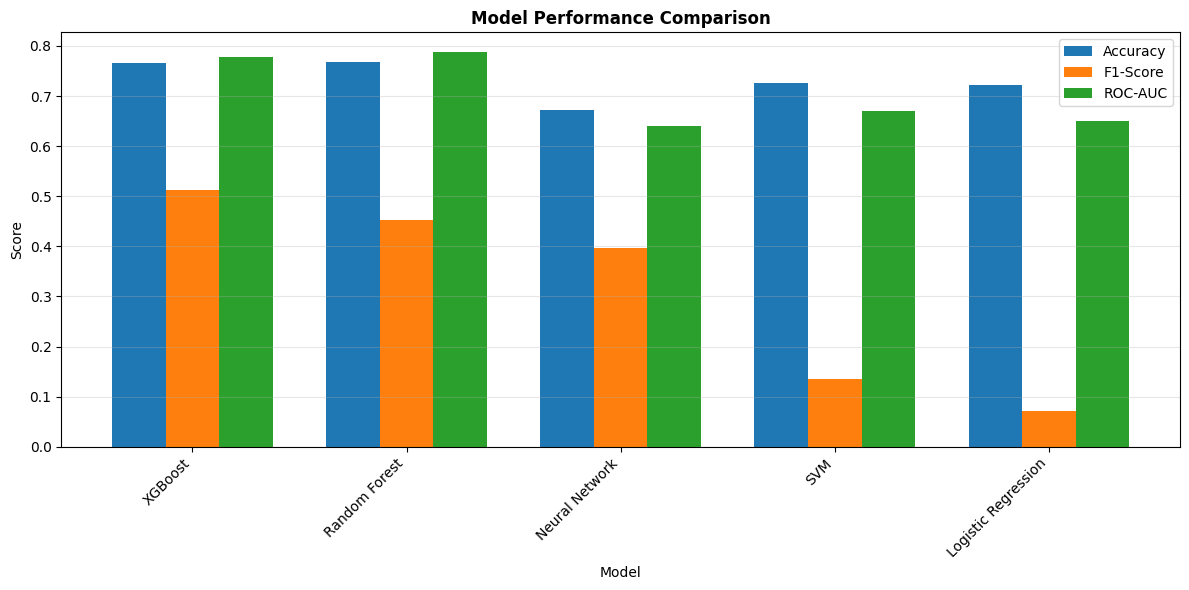

In [11]:
plt.figure(figsize=(12, 6))
x = np.arange(len(results))
width = 0.25

plt.bar(x - width, results['Accuracy'], width, label='Accuracy')
plt.bar(x, results['F1-Score'], width, label='F1-Score')
plt.bar(x + width, results['ROC-AUC'], width, label='ROC-AUC')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison', fontweight='bold')
plt.xticks(x, results['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Feature Importance

In [12]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature Importance (Random Forest):")
print("="*60)
for i in range(len(feature_cols)):
    print(f"{i+1}. {feature_cols[indices[i]]:30s}: {importances[indices[i]]:.4f}")


Feature Importance (Random Forest):
1. strength                      : 0.1416
2. ccs_value                     : 0.1275
3. prompt_ratio                  : 0.1044
4. strength_ccs_interaction      : 0.1010
5. strength_gs_interaction       : 0.0935
6. gs_value                      : 0.0868
7. prompt_length                 : 0.0802
8. num_iterations                : 0.0773
9. qr_version                    : 0.0716
10. negative_prompt_length        : 0.0507
11. ec_encoded                    : 0.0338
12. image_resolution              : 0.0288
13. is_optimal_params             : 0.0027


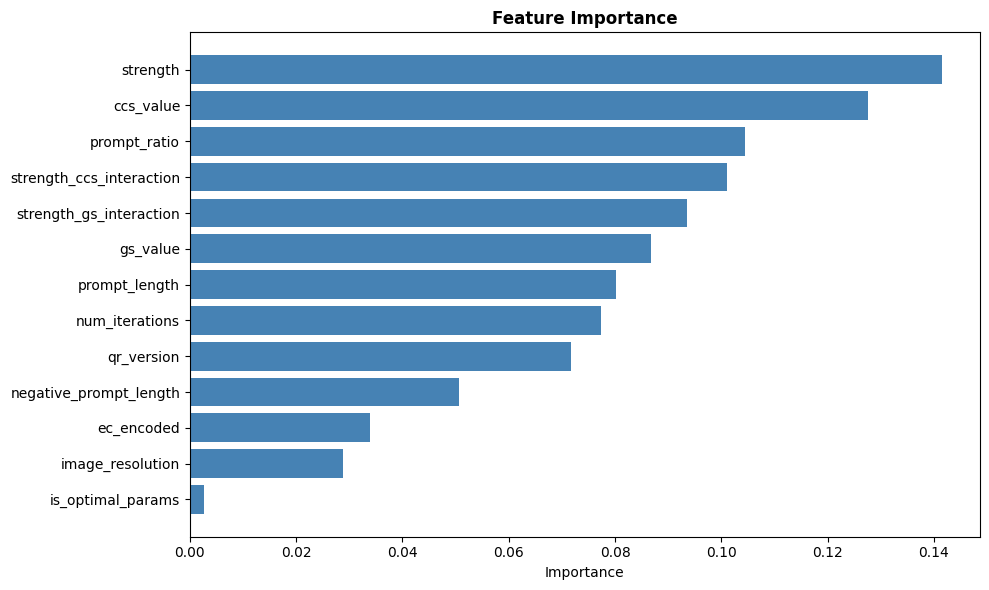

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], color='steelblue')
plt.yticks(range(len(importances)), [feature_cols[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importance', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Save Best Model

In [14]:
os.makedirs('../models/trained_models', exist_ok=True)

joblib.dump(rf, '../models/trained_models/best_model.pkl')
joblib.dump(scaler, '../models/trained_models/scaler.pkl')
joblib.dump(le, '../models/trained_models/label_encoder.pkl')
joblib.dump(feature_cols, '../models/trained_models/feature_names.pkl')

print("\n✓ Best model (Random Forest) saved!")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_pred_rf):.4f}")


✓ Best model (Random Forest) saved!
Test Accuracy: 0.7680
Test F1-Score: 0.4528


## Test Prediction

In [15]:
test_params = {
    'strength': 0.6,
    'ccs_value': 1.5,
    'gs_value': 12.0,
    'prompt_length': 3,
    'negative_prompt_length': 10,
    'qr_version': 10,
    'image_resolution': 512,
    'num_iterations': 50,
    'error_correction_level': 'H'
}

features = [
    test_params['strength'],
    test_params['ccs_value'],
    test_params['gs_value'],
    test_params['prompt_length'],
    test_params['negative_prompt_length'],
    test_params['qr_version'],
    test_params['image_resolution'],
    test_params['num_iterations'],
    le.transform([test_params['error_correction_level']])[0],
    test_params['strength'] * test_params['ccs_value'],
    test_params['strength'] * test_params['gs_value'],
    test_params['prompt_length'] / (test_params['negative_prompt_length'] + 1),
    int((test_params['strength'] >= 0.5) & (test_params['strength'] <= 0.7))
]

features_scaled = scaler.transform([features])
prediction = rf.predict(features_scaled)[0]
probability = rf.predict_proba(features_scaled)[0]

print("\nTest Prediction:")
print(f"Scannable: {bool(prediction)}")
print(f"Confidence: {probability[prediction]*100:.1f}%")

print("\n" + "="*60)
print("✓ MODEL TRAINING COMPLETE!")
print("="*60)


Test Prediction:
Scannable: True
Confidence: 90.6%

✓ MODEL TRAINING COMPLETE!
